<a href="https://colab.research.google.com/github/kulkasturi/MaskRCNN_Archi/blob/main/Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# Create a new folder
folder_name = "/content/dataset/images"
os.makedirs(folder_name, exist_ok=True)

# Verify the folder was created
!ls /content

dataset  sample_data


In [1]:
# Install Detectron2
!pip install -U torch torchvision
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Check if Detectron2 is installed
import detectron2
print("Detectron2 Installed Successfully!")


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-e3gf4mcz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-e3gf4mcz
  Resolved https://github.com/facebookresearch/detectron2.git to commit c69939aa85460e8135f40bce908a6cddaa73065f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.0 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp31

Detectron2 Installed Successfully!


In [1]:
import os

# Create a new folder
folder_name = "/content/dataset/images"
os.makedirs(folder_name, exist_ok=True)

# Verify the folder was created
!ls /content


dataset  sample_data


In [2]:
!ls /content/dataset/images
!ls /content/dataset/result.json


Archi10.jpg  Archi13.jpg  Archi14.jpg  Archi6.png
/content/dataset/result.json


In [4]:
import os
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
import cv2
import random


In [15]:
def get_dataset_dicts(img_dir):
    import json
    from detectron2.structures import BoxMode

    # Path to the COCO-style annotations file
    json_file = os.path.join(img_dir, "/content/dataset/result.json")  # Ensure this path points to your annotations file
    with open(json_file) as f:
        coco_data = json.load(f)

    dataset_dicts = []
    for img in coco_data["images"]:
        # Each image record in the dataset
        record = {
            "file_name": os.path.join(img_dir, img["file_name"]),  # Image file path
            "image_id": img["id"],  # Unique image ID
            "height": img["height"],  # Image height
            "width": img["width"],  # Image width
            "annotations": []  # Placeholder for image annotations
        }

        # Process annotations for each image
        for ann in coco_data["annotations"]:
            if ann["image_id"] == img["id"]:
                record["annotations"].append({
                    "bbox": ann["bbox"],  # Bounding box (xmin, ymin, width, height)
                    "bbox_mode": BoxMode.XYWH_ABS,  # Bounding box format
                    "category_id": ann["category_id"],  # Category ID (mapped to class)
                    "segmentation": ann["segmentation"]  # Segmentation data if available
                })

        # Append the processed record to the dataset
        dataset_dicts.append(record)

    return dataset_dicts

# Register the dataset with Detectron2
dataset_name = "archi_Image"  # Replace with your dataset name
DatasetCatalog.register(dataset_name, lambda: get_dataset_dicts("/content/dataset/images"))  # Adjust path to images
MetadataCatalog.get(dataset_name).thing_classes = ["arrow_line" , "circle_curve" , "cross" , "dimension" , "door" , "furniture" , "index_table" , "other" , "pattern" , "staircase" , "textbox" , "wall" , "window"]  # Replace with your actual class names
metadata = MetadataCatalog.get(dataset_name)


In [16]:
# Test Dataset Registration
dataset_dicts = get_dataset_dicts("/content/dataset/images")
print(f"Dataset size: {len(dataset_dicts)}")
print(f"First entry in dataset: {dataset_dicts[0]}")


Dataset size: 4
First entry in dataset: {'file_name': '/content/dataset/images/Archi6.png', 'image_id': 0, 'height': 472, 'width': 590, 'annotations': [{'bbox': [123.51922912076012, 115.0164667362516, 10.313350376581809, 57.91342903772875], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 11, 'segmentation': [[133.83257949734192, 115.80980138060406, 124.31256376511256, 115.0164667362516, 123.51922912076012, 172.1365611296279, 129.8659062755797, 172.92989577398035, 130.65924091993216, 123.74314782412854]]}, {'bbox': [163.97929598273495, 115.0164667362516, 47.60007866114694, 6.346677154819588], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 11, 'segmentation': [[164.77263062708744, 115.0164667362516, 163.97929598273495, 121.36314389107119, 211.5793746438819, 120.56980924671873, 211.5793746438819, 115.80980138060406]]}, {'bbox': [240.93275648492246, 84.0764156065061, 36.4933936402127, 38.080062928917556], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 11, 'segmentation': [[241.7

In [17]:
cfg = get_cfg()
cfg.merge_from_file("/content/Base-RCNN-FPN.yaml")

cfg.DATASETS.TRAIN = ("architecture_Image",)
cfg.DATASETS.TEST = ()  # No evaluation during training
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500  # Adjust as per your dataset size
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13   # Update for your dataset classes

# Output directory
cfg.OUTPUT_DIR = "/content/outputs"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [18]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[11/28 15:13:04 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  roi_heads.mask_head.mask_fcn1.{bias, weight}
  roi_heads.mask_head.mask_fcn2.{bias, weight}
  roi_heads.mask_head.mask_fcn3.{bias, weight}
  roi_heads.mask_head.mask_fcn4.{bias, weight}
  roi_heads.mask_head.deconv.{bias, weight}
  roi_heads.mask_head.predictor.{bias, weight}


[11/28 15:13:04 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/28 15:13:17 d2.utils.events]:  eta: 0:03:34  iter: 19  total_loss: 5.696  loss_cls: 2.58  loss_box_reg: 0.3465  loss_rpn_cls: 2.309  loss_rpn_loc: 0.4481    time: 0.4385  last_time: 0.4134  data_time: 0.0232  last_data_time: 0.0104   lr: 9.7405e-06  max_mem: 2856M
[11/28 15:13:34 d2.utils.events]:  eta: 0:03:21  iter: 39  total_loss: 3.816  loss_cls: 2.331  loss_box_reg: 0.3384  loss_rpn_cls: 0.5854  loss_rpn_loc: 0.4123    time: 0.4347  last_time: 0.4205  data_time: 0.0124  last_data_time: 0.0051   lr: 1.9731e-05  max_mem: 2856M
[11/28 15:13:42 d2.utils.events]:  eta: 0:03:10  iter: 59  total_loss: 2.923  loss_cls: 1.867  loss_box_reg: 0.3755  loss_rpn_cls: 0.2945  loss_rpn_loc: 0.3543    time: 0.4321  last_time: 0.4339  data_time: 0.0105  last_data_time: 0.0241   lr: 2.972e-05  max_mem: 2856M
[11/28 15:13:51 d2.utils.events]:  eta: 0:03:02  iter: 79  total_loss: 2.362  loss_cls: 1.263  loss_box_reg: 0.3846  loss_rpn_cls: 0.2491  loss_rpn_loc: 0.3506    time: 0.4312  last_time: 0.

In [19]:
os.makedirs("/content/outputs/", exist_ok=True)


In [20]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer

# Ensure the dataset name is correct, same as the one used during dataset registration
dataset_name = "archi_Image"  # Replace with the actual name used when registering the dataset

# Update cfg to use your dataset for testing
cfg.DATASETS.TEST = (dataset_name,)  # Use the same dataset for testing

# Initialize the COCOEvaluator
evaluator = COCOEvaluator(dataset_name, cfg, False, output_dir="/content/outputs/")

# Build the test data loader
val_loader = build_detection_test_loader(cfg, dataset_name)

# Create a trainer instance (if not already created)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Run the evaluation
print(inference_on_dataset(trainer.model, val_loader, evaluator))


WARNING [11/28 15:22:26 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/28 15:22:26 d2.evaluation.coco_evaluation]: Trying to convert 'archi_Image' to COCO format ...
[11/28 15:22:26 d2.data.datasets.coco]: Converting annotations of dataset 'archi_Image' to COCO format ...)
[11/28 15:22:26 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[11/28 15:22:26 d2.data.datasets.coco]: Conversion finished, #images: 4, #annotations: 163
[11/28 15:22:26 d2.data.datasets.coco]: Caching COCO format annotations at '/content/outputs/archi_Image_coco_format.json' ...
[11/28 15:22:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/28 15:22:26 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/28 15:22:26 d2.data.co

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  roi_heads.mask_head.mask_fcn1.{bias, weight}
  roi_heads.mask_head.mask_fcn2.{bias, weight}
  roi_heads.mask_head.mask_fcn3.{bias, weight}
  roi_heads.mask_head.mask_fcn4.{bias, weight}
  roi_heads.mask_head.deconv.{bias, weight}
  roi_heads.mask_head.predictor.{bias, weight}


[11/28 15:22:27 d2.evaluation.evaluator]: Start inference on 4 batches
[11/28 15:22:28 d2.evaluation.evaluator]: Total inference time: 0:00:00.191693 (0.191693 s / iter per device, on 1 devices)
[11/28 15:22:28 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.116038 s / iter per device, on 1 devices)
[11/28 15:22:28 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/28 15:22:28 d2.evaluation.coco_evaluation]: Saving results to /content/outputs/coco_instances_results.json
[11/28 15:22:28 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[11/28 15:22:28 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[11/28 15:22:28 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[11/28 15:22:28 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[11/28 15:22:28 d2.evaluation.fast_eval_api

[11/28 15:30:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/outputs/model_final.pth ...


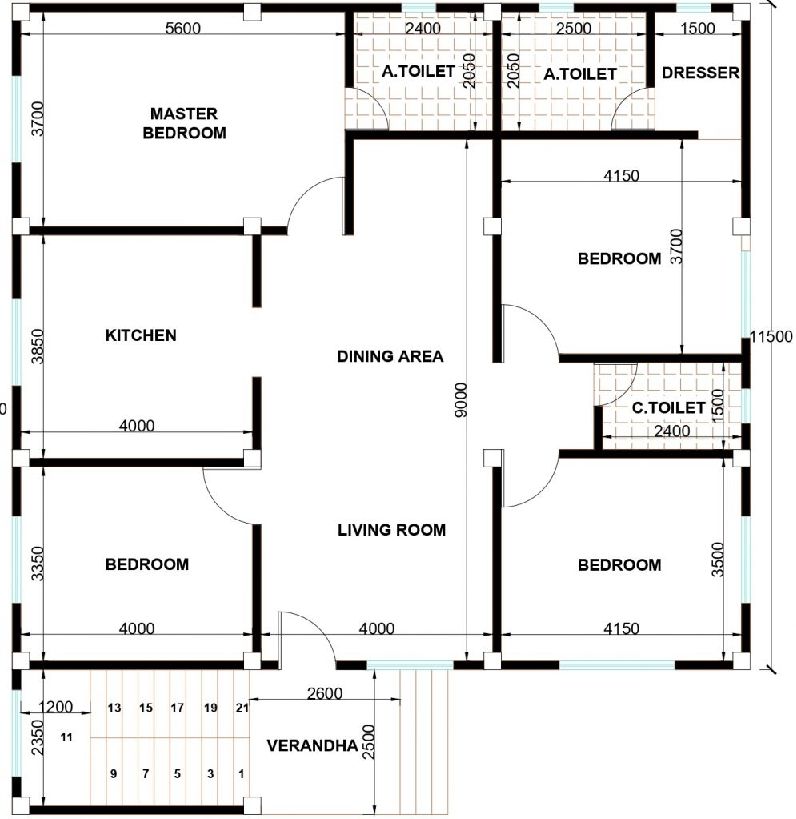

In [24]:


from detectron2.utils.visualizer import Visualizer
import cv2
from google.colab.patches import cv2_imshow  # Import cv2_imshow

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/outputs/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for predictions
predictor = DefaultPredictor(cfg)

image_path = "/content/dataset/images/floorplan1.jpg"
image = cv2.imread(image_path)
outputs = predictor(image)

v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])  # Display the image



In [1]:
!git clone https://github.com/kulkasturi/MaskRCNN_Archi.git


Cloning into 'MaskRCNN_Archi'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [3]:
!git add .



fatal: not a git repository (or any of the parent directories): .git
